<div class="title">Implementing an SVC Model</div>
<div class="subtitle">Métodos Avanzados en Aprendizaje Automático</div>
<div class="author">Carlos María Alaíz Gudín &mdash; Universidad Autónoma de Madrid</div>

---
<div style="font-size: large; font-weight: bold; margin-left: 6em;"><p>Team Number and Names: <u> 01 </u></div>

* Iñigo Martínez Ciriza
* Rafael Domínguez Sáez


**Configuration**

This cell defines the general configuration of Jupyter Notebook.

In [57]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

This cell imports the packages to be used.

In [58]:
# Standard packages.
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

# Custom packages.
from ml import (
	generate_dataset_moons,
	plot_dataset_clas,
	plot_svc,
)

# Initialisations.
matplotlib.rc("figure", figsize=(15, 5))
seed = 123

# Implementing an SVC Model

## Introduction

This practical assignment consists in implementing a simplified version of the SVC class of *scikit-learn*.

This class will contain two fundamentals routines, one for training a non-linear SVC (using the RBF kernel), based on the SMO algorithm for solving the dual optimization problem, and the other one for predicting over new out-of-sample points.

## SMO Algorithm

### Optimization Problem

The dual optimization problem for the Soft-Margin SVM is:
$$
 \left \{ \begin{array}{l} \min_{\boldsymbol{\alpha} \in \mathbb{R}^N} \frac{1}{2} \boldsymbol{\alpha}^\intercal \tilde{\mathbf{K}} \boldsymbol{\alpha} - \boldsymbol{\alpha}^\intercal \mathbf{1} \\ \text{ s.t. } \boldsymbol{\alpha}^\intercal \mathbf{y} = 0 , 0 \le \boldsymbol{\alpha} \le C ,
 \end{array} \right .
$$
where $\tilde{k}_{ij} = y_i y_j \mathcal{K}(\mathbf{x}_i, \mathbf{x}_j)$.

This optimization problem is a QP problem, which is usually solved using an *ad hoc* algorithm: Sequential Minimal Optimization (SMO).

### SMO and Coordinate Descent

The main idea behind SMO is that the optimization problem is too involved to be solved as a whole, but it can be largely simplified considering only a few variables at a time.
In this divide-and-conquer approach, called coordinate descent, the objective function is iteratively minimized over the different variables.

In particular, SMO deals with two variables, the smaller working group that can be modified while respecting the constraints.
Formally, the algorithm updates the current $\alpha^\text{old}_i$ and $\alpha^\text{old}_j$ coefficients to some new values $\alpha_i$ and $\alpha_j$, assuming that $\boldsymbol{\alpha}^\text{old}$ satisfies $(\boldsymbol{\alpha}^\text{old})^\intercal \mathbf{y} = 0$. In order to keep respecting the constraint in the new estimation, the following equation needs to be fulfilled:
\begin{align*}
 & y_i \alpha^\text{old}_i + y_j \alpha^\text{old}_j = y_i \alpha_i + y_j \alpha_j \\
 &\implies y_i (\alpha_i - \alpha^\text{old}_i) = - y_j (\alpha_j - \alpha^\text{old}_j) \\
 &\implies \alpha_i = \alpha^\text{old}_i - y_i y_j (\alpha_j - \alpha^\text{old}_j) .
\end{align*}

For simplicity, one can assume that the update for the $j$-th coefficient is given by $\alpha_j = \alpha^\text{old}_j + d$, and hence the optimization problem becomes a simple one-dimensional minimization.
Therefore, it can be solved by computing the derivative with respect to $d$ and equating to $0$.
After some derivations, the optimum unconstrained update turns out to be:
\begin{align*}
 d &= \frac{y_j (E(\mathbf{x}_j, y_j) - E(\mathbf{x}_i, y_i))}{\kappa} , \text{ where} \\
 \kappa &= 2 \mathcal{K}(\mathbf{x}_i, \mathbf{x}_j) - \mathcal{K}(\mathbf{x}_i, \mathbf{x}_i) - \mathcal{K}(\mathbf{x}_j, \mathbf{x}_j) , \text{ and} \\
 E(\mathbf{x}, y) &= \sum_{i = 1}^N \alpha^\text{old}_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) - y .
\end{align*}

### Clipping

The previous update does not take into account the box constrains $0 \le \alpha_i, \alpha_j \le C$.
In order to satisfy these constraints for both $\alpha_i$ and $\alpha_j$, $\alpha_j$ has to be clipped to the interval $[L, H]$, where
$$
 \begin{cases}
  L = \max(0, \alpha^\text{old}_j - \alpha^\text{old}_i), & H = \min(C, C - \alpha^\text{old}_i + \alpha^\text{old}_j) & \text{if } y_i \neq y_j , \\
  L = \max(0, \alpha^\text{old}_j + \alpha^\text{old}_i - C), & H = \min(C, \alpha^\text{old}_i + \alpha^\text{old}_j) & \text{if } y_i = y_j .
 \end{cases}
$$

Therefore, the update for $\alpha_j$ becomes:
$$ \alpha_j = \min(\max(\alpha^\text{old}_j + d, L), H) , $$
and, as mentioned above, the corresponding update for $\alpha_i$ is:
$$ \alpha_i = \alpha^\text{old}_i - y_i y_j (\alpha_j - \alpha^\text{old}_j) . $$

### Selecting the Working Pair

There are different methods for selecting the working pair of coefficients $(i, j)$ that will be updated.
Usually, first or second order information is used to choose the working set, trying to find those that will provide the largest minimization of the objective function.

Nevertheless, in this work a simplified version of SMO will be implemented.
The first coefficient $i$ will be selected just iteratively, cycling over all the possible values $i = 1, 2, \dotsc, N$. The second coefficient $j$ is selected randomly over the remaining possible values $j \neq i$.

It should be noted that this approach will not guarantee the convergence in general, since not all possible pairs $(i, j)$ are explored, but it will work in most problems.

### Stopping Criteria

The algorithm will be terminated when a certain maximum number of iterations is reached (for each iteration, all the coefficients are updated), or when after one iteration the total change of the coefficients is smaller than a certain tolerance, $\| \boldsymbol{\alpha} - \boldsymbol{\alpha}^\text{old}\| < \epsilon$.

Since the working pair is generated randomly, it can happen that after a whole iteration the changes are smaller than $\epsilon$ not because the optimization is finished, but because of "bad luck". A workaround is to set $\epsilon = 0$ to force all the iterations.

### Computing the Intercept

Once the optimum dual coefficients $\boldsymbol{\alpha}^*$ have been estimated, the intercept $b^*$ can be computed knowing that any support vector $\mathbf{x}_k$ with $0 < \alpha^*_k < C$ satisfies:
$$ b^* = y_k - \sum_{i = 1}^N \alpha^*_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}_k) . $$

This equality is usually averaged over all the possible vectors $k$ satisfying $0 < \alpha^*_k < C$ for reasons of numerical stability.

### Prediction

Once the model is trained and the optimal parameters $\boldsymbol{\alpha}^*$ and $b^*$ are known, the score predicted over a new sample $\mathbf{x}$ is:
$$ f(\mathbf{x}) = \sum_{i = 1}^N \alpha^*_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) + b^* . $$

Finally, the class is assigned with:
$$ \hat{y} = \operatorname{sign}(f(\mathbf{x})) . $$

## Implementation of the SVC Model

### Requirements

The objective of this assignment is to complete the class `MySVC` sketched below, which should contain at least the following methods.

---
```python
__init__(self, C=1.0, gamma="scale", tol=0.0001, max_iter=10000)
```
* This is the construction method for the class, with the following parameters:
    * `C`: Regularization parameter $C$ of the SVC.
    * `gamma`: Kernel parameter $\gamma$ of the RBF kernel.
    * `tol`: Tolerance for the stopping criterion $\epsilon$.
    * `max_iter`: Maximum number of iterations (in the sense of epochs; each iteration contains a pass through all the coefficients).
* This method should only store the parameters in fields of the class, to be used when needed.

---
```python
fit(self, x, y)
```
* This is the training method, with the following parameters:
    * `x`: Training data matrix $\mathbf{X} \in \mathbb{R}^{N \times d}$.
    * `y`: Vector of labels $\mathbf{y}$, with $y_i \in \{-1, +1\}$.
* This method should solve the dual optimization problem, storing the obtained coefficients and other useful information in fields of the class.

---
```python
decision_function(self, x)
```
* This is the method that computes the output of the SVC, with the following parameters:
    * `x`: Test data matrix $\mathbf{X}' \in \mathbb{R}^{N' \times d}$.
* This method should predict the output (the score) of the SVC, using the information stored in the fields of the class, and return it as a vector.

---
```python
predict(self, x)
```
* This is the method that computes the predicted class of the SVC, with the following parameters:
    * `x`: Test data matrix $\mathbf{X}' \in \mathbb{R}^{N' \times d}$.
* This method should predict the assigned class of the SVC, using the information stored in the fields of the class, and return it as a vector.

### Recommendations

Additional auxiliary methods can be defined to simplify the code.
Some suggestions are:

1. A method to compute the output of the SVC, with the current estimated parameters but without considering the intercept:
$$ \sum_{i = 1}^N \alpha_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) . $$
1. A method to compute $E(\mathbf{x}, y)$.
1. A method to compute the lower and upper bounds $L$ and $H$ for the clipping of the update.
1. A method to estimate $b^*$.

### Implementation

<div class="qst">

* Complete the `MySVC` class below, satisfying the described requirements.

</div>

In [59]:
class MySVC:
    """
    SVC with a simplified version of SMO.
    """

    def __init__(self, C:float = 1.0, gamma:str = "scale", tol:float = 0.0001, max_iter:int = 10000):
        """
        Initializes the SVC model with hyperparameters.

        Parameters:
            C (float): Regularization parameter. Default is 1.0.
            gamma (str): Kernel coefficient. Options are "scale", "auto", or a float value. Default is "scale".
            tol (float): Tolerance for stopping criteria. Default is 0.0001.
            max_iter (int): Maximum number of iterations for training. Default is 10000.
        """    
        self.C = C
        self.kernel = gamma
        self.tol = tol
        self.max_iter = max_iter
        self.a = None
        self.b = 0
        self.x = None
        self.y = None
        self.support_vectors_ = None

    def __rbf_kernel(self, x1, x2):
        """
        Computes the RBF kernel between two samples.

        Parameters:
            x1 (np.ndarray): First sample.
            x2 (np.ndarray): Second sample.

        Returns:
            float: RBF kernel value.
        """
        return np.exp(-self.kernel * np.linalg.norm(x1 - x2) ** 2)

    def __compute_kernel_matrix(self, x):
        """
        Computes the full kernel matrix for the training data.

        Parameters:
            x (np.ndarray): Training data (features).

        Returns:
            np.ndarray: Kernel matrix.
        """
        N = x.shape[0]
        return np.array([[self.__rbf_kernel(x[i], x[j]) for j in range(N)] for i in range(N)])

    def __E(self, i, K):
        """
        Computes the prediction error for a given sample.

        Parameters:
            i (int): Index of the sample.
            K (np.ndarray): Precomputed kernel matrix.

        Returns:
            float: Prediction error for the sample.
        """
        return np.sum(self.a * self.y * K[:, i]) - self.y[i]
    
    def __clip(self, a_j_new, i, j, y):
        """
        Clips the value of a_j to ensure it stays within the permissible range.

        Parameters:
            a_j_new (float): Updated value of alpha_j.
            i (int): Index of the first sample.
            j (int): Index of the second sample.
            y (np.ndarray): Labels of the training data.

        Returns:
            float: Clipped value of alpha_j.
        """
        if y[i] != y[j]:
            L, H = max(0, self.a[j] - self.a[i]), min(self.C, self.C - self.a[i] + self.a[j])
        else:
            L, H = max(0, self.a[i] + self.a[j] - self.C), min(self.C, self.a[i] + self.a[j])
        return np.clip(a_j_new, L, H)

    def __compute_intercept(self, K):
        """
        Computes the intercept term (b) using the support vectors.

        Parameters:
            y (np.ndarray): Labels of the training data.
            K (np.ndarray): Precomputed kernel matrix.

        Returns:
            float: Intercept term (b).
        """
        sv_indices = (self.a > 0) & (self.a < self.C)
        return np.mean([
            self.y[k] - np.sum(self.a * self.y * K[:, k])
            for k in range(len(self.y)) if sv_indices[k]
        ])

    def fit(self, x, y):
        """
        Fits the SVC model to the training data using the simplified SMO algorithm.

        Parameters:
            x (np.ndarray): Training data (features).
            y (np.ndarray): Training data (labels).

        Returns:
            MySVC: The fitted model.
        """
        n_dat = x.shape[0]
        n_dim = x.shape[1]

        if self.kernel == "scale":
            self.kernel = 1.0 / (n_dim * x.var())
        elif self.kernel == "auto":
            self.kernel = 1.0 / n_dim

        self.a = np.zeros(n_dat)

        self.x = x
        self.y = y
        self.b = 0

        K = self.__compute_kernel_matrix(x)

        for _ in range(self.max_iter):

            for i in range(n_dat):
                old_a = np.copy(self.a)
                j = self.choose_j(i)
                
                E_i = self.__E(i, K)
                E_j = self.__E(j, K)

                kappa = 2 * K[i, j] - K[i, i] - K[j, j]

                d = y[j] * (E_j - E_i) / kappa

                self.a[j] = self.__clip(old_a[j] + d, i, j, y)
                self.a[i] = old_a[i] - y[i] * y[j] * (self.a[j] - old_a[j])
                
            if np.any(np.isnan(self.a)) or np.any(np.isinf(self.a)):
                raise ValueError("NaN or Inf detected in dual coefficients a during training.")

            diff = np.linalg.norm(self.a - old_a)
            if diff < self.tol:
                break
        
        self.b = self.__compute_intercept(K)
        if np.any(np.isnan(self.b)) or np.any(np.isinf(self.b)):
                raise ValueError("NaN or Inf detected in dual coefficients b during training.")

        self.support_vectors_ = x[self.a > 0]

        return self

    def decision_function(self, x):
        """
        Computes the decision function values for the input data.

        Parameters:
            x (np.ndarray): Input data.

        Returns:
            np.ndarray: Decision scores.
        """
        return np.array([
            np.sum(self.a * self.y * [self.__rbf_kernel(xi, sv) for sv in self.x]) + self.b
            for xi in x
        ])

    def predict(self, x):
        """
        Predicts the labels for the input data.

        Parameters:
            x (np.ndarray): Input data.

        Returns:
            np.ndarray: Predicted labels.
        """
        return np.sign(self.decision_function(x))

    def choose_j(self, i):
        """
        Randomly selects an index j different from i.

        Parameters:
            i (int): Index of the first sample.

        Returns:
            int: Index of the second sample.
        """
        j = np.arange(len(self.a))
        return np.random.choice(j[j != i])
    
    def get_classification_status(self, x, y):
        """
        Classifies training points as well or badly classified.

        Returns:
            tuple: Two arrays, (well_classified, badly_classified).
        """
        decision_values = self.decision_function(x)
        well_classified = x[(y * decision_values) > 0]
        badly_classified = x[(y * decision_values) <= 0]
        return well_classified, badly_classified
    
    def get_supporting_hyperplane_points(self, x, y):
        """
        Finds training points that lie exactly on the supporting hyperplanes.

        Returns:
            np.ndarray: Points on the supporting hyperplanes.
        """
        decision_values = self.decision_function(x)
        return x[np.isclose(y * decision_values, 1, atol=1e-3)]
    
    def get_wrong_side_well_classified(self, x, y):
        """
        Identifies points that are on the wrong side of the hyperplanes but still correctly classified.

        Returns:
            np.ndarray: Points on the wrong side of the hyperplanes but well classified.
        """
        
        decision_values = self.decision_function(x)
        return x[(y * decision_values > 0) & (y * decision_values < 1)]


### Comparative with *scikit-learn*

The following cell generates the *moons* dataset, dividing it into train and test splits, and depicting it.

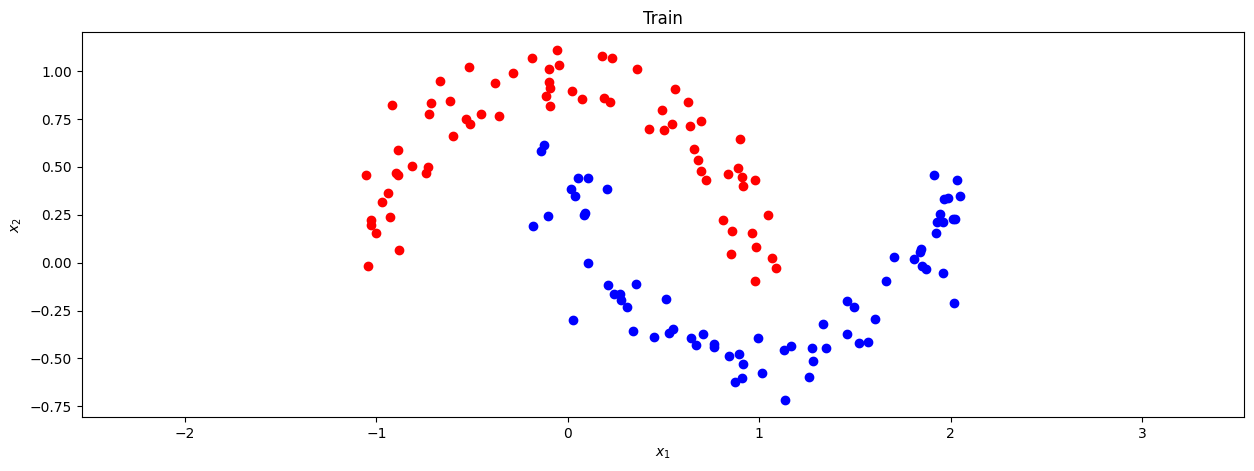

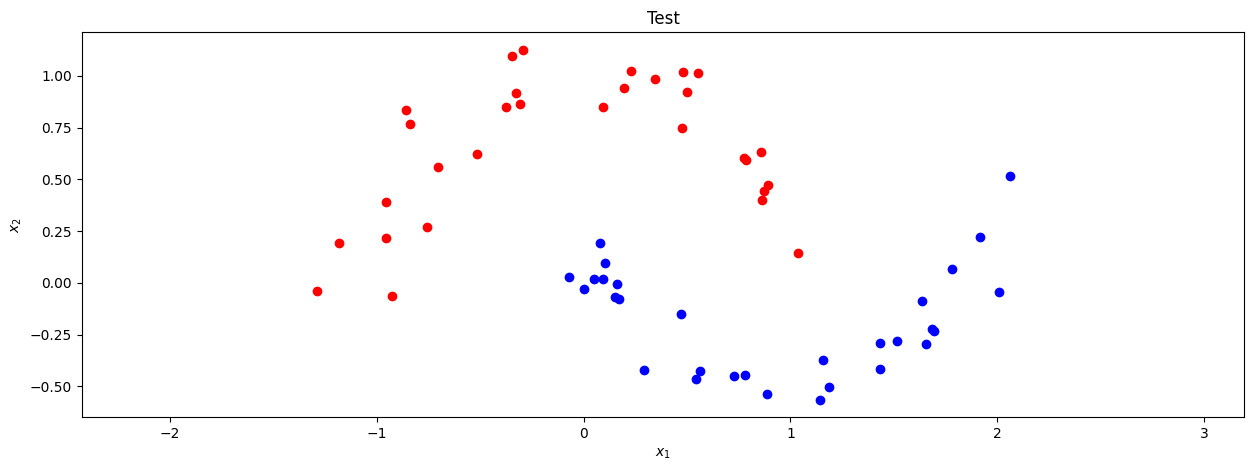

In [60]:
x, y = generate_dataset_moons(seed)
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.3, random_state=seed)

plot_dataset_clas(x_tr, y_tr)
plt.title("Train")
plt.show()
plot_dataset_clas(x_te, y_te)
plt.title("Test")
plt.show()

<div class="qst">

* Train an SVC model over the training data (`x_tr`, `y_tr`), using both the `SVC` class of *scikit-learn* and the implemented `MySVC` class.
* Predict using the previous two models over the test data (`x_te`, `y_te`).
* Compare that both classes provide the same outputs (in terms of the decision function and of the predicted class), describing the obtained results.
  If needed, reduce the default stopping tolerance and/or increase the default maximum number of iterations.

</div>

In [61]:
# Training of both models
C = 1
gamma = "scale"

model_my = MySVC(C=C, gamma=gamma, tol=0)
model_sk = SVC(C=C, gamma=gamma)

model_my.fit(x_tr, y_tr)
model_sk.fit(x_tr, y_tr)

SVC(C=1)

In [62]:
# Predicitons of both models
predictions_my = model_my.predict(x_te)
predictions_sk = model_sk.predict(x_te)

# Comparison of both models
accuracy_my = accuracy_score(y_te, predictions_my)
accuracy_sk = accuracy_score(y_te, predictions_sk)

conf_matrix_my = confusion_matrix(y_te, predictions_my)
conf_matrix_sk = confusion_matrix(y_te, predictions_sk)

print(f"Predicted classes of MySVC: \n{predictions_my}")
print(f"Predicted classes of scikit-learn SVC: \n{predictions_sk}")
print()
print(f"Accuracy of MySVC: {accuracy_my}")
print(f"Accuracy of scikit-learn SVC: {accuracy_sk}")
print()
print(f"Confussion matrix of MySVC: \n{conf_matrix_my}")
print(f"Confussion of scikit-learn SVC: \n{conf_matrix_sk}")

Predicted classes of MySVC: 
[ 1. -1.  1. -1. -1. -1.  1.  1. -1. -1.  1. -1.  1.  1.  1. -1. -1.  1.
 -1.  1. -1. -1. -1.  1.  1.  1. -1.  1.  1. -1. -1. -1.  1.  1. -1. -1.
  1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1.  1. -1.
 -1.  1. -1. -1.  1.  1.]
Predicted classes of scikit-learn SVC: 
[ 1 -1  1 -1 -1 -1  1  1 -1 -1  1 -1  1  1  1 -1 -1  1 -1  1 -1 -1 -1  1
  1  1 -1  1  1 -1 -1 -1  1  1 -1 -1  1 -1 -1  1  1  1  1  1  1  1  1 -1
 -1 -1 -1 -1  1 -1 -1  1 -1 -1  1  1]

Accuracy of MySVC: 1.0
Accuracy of scikit-learn SVC: 1.0

Confussion matrix of MySVC: 
[[30  0]
 [ 0 30]]
Confussion of scikit-learn SVC: 
[[30  0]
 [ 0 30]]


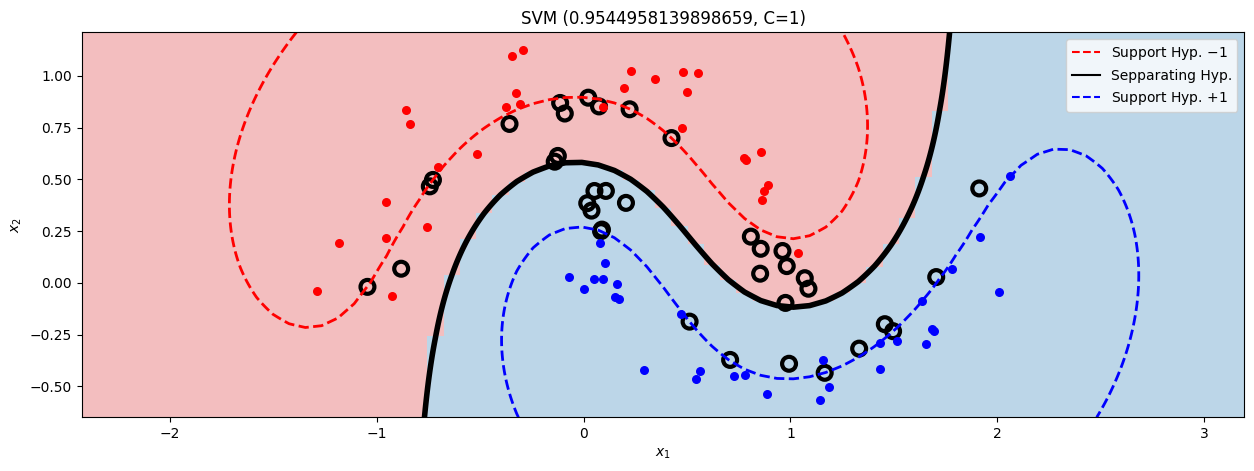

In [63]:
plot_svc(x_te, y_te, model_my)

As it can be seen, the SVC model created by us and the model implemented by sci-kit learn both yield the same results for the class of the test data.

Moreover, the predictions made by these models are perfect as it can be seen from the accuracy test and the confussion matrix.

We can also see this behaviour from the plot of the hyperplane of our model, where we can see easily that the hyperplane separates both classes perfectly.

### Understanding the SVM

<div class="qst">

* Considering the model created with the `MySVC` class:
    * Extract the list of support vectors, explaining the followed approach.
    * Extract the list of training points bad and well classified, explaining the followed approach.
    * Extract the list of training points that lie over the supporting hyperplanes.
    * Extract the list of training points located on the wrong side of the supporting hyperplanes, but that are well classified.
* What are the conditions over the dual coefficients $\alpha_i$ that characterize the previous lists (if any)?

</div>

1. The support vectors are the vectors of the training set that have a dual coefficient $\alpha_i > 0 $. In our model, these coefficients correspond to the attribute `self.a`.

   So, if we get the indeces $i$ when $\alpha_i > 0$ and then we recover the points corresponding to the training data `self.x` we extract the list of suppor vectors. This means that these points belong to the well separated class.

2. The training points bad and well separated we need to use the `decision_function` in order to compare the predictions with the actual labels `self.y`.

   The well classified points are those that fulfill the condition $y_i \cdot f(x_i) > 0$ where $f(x_i)$ is the value of the decision function and the badly classified points are those that fulfull the condition $y_i \cdot f(x_i) \leq 0$.

3. The points that lie over the supporting hyperplanes are those that fulfill the condition $y_i \cdot f(x_i) = 1$. Using a similar approach as before, using `decision_function` we will extract the points that follow the previous condition (we will use a tolerance due to possible numerical errors). As we now, the support vectors also belong to this category.

4. The training points that are located on the wrong side of the supporting hyperplanes but are well classified are those that fulfill the condition $0 < y_i \cdot f(x_i) < 1$. So firstly we will filter the points that are well classified ($y_i \cdot f(x_i) > 0$) and then we will filter the points that are on the wrong side of the hyperplane ($y_i \cdot f(x_i) < 1$).

#### TODO: Conditions over the dual coefficients $\alpha_i$
1. The support vectors, as previously stated are those where $\alpha_i > 0$.

2. For the well clasified points, ...

   For the badly classified points, ...

3. For the points that lie over the supporting hyperplanes...

4. For the points that are on the wrong side but are well classifed...

Support vectors of MySVC:
[[ 0.96183352  0.1537731 ]
 [ 1.91298824  0.45619617]
 [ 1.33244065 -0.31819234]
 [ 0.22290922  0.83884937]
 [ 1.06955833  0.02232741]
 [-0.35766834  0.76800854]
 [ 1.08735914 -0.02851312]
 [-0.11291556  0.86941299]
 [ 0.42532529  0.69964593]
 [ 0.85661518  0.16443333]
 [ 0.03861244  0.3490792 ]
 [-0.88141539  0.06810258]
 [ 0.10814845  0.44418536]
 [-1.04434178 -0.01958817]
 [-0.12405703  0.61329342]
 [ 0.85386488  0.04412433]
 [ 0.08904053  0.25713775]
 [ 0.02300611  0.89485816]
 [ 0.01807798  0.38488377]
 [ 0.20522809  0.38637198]
 [ 0.05289285  0.44384578]
 [-0.72779681  0.49724573]
 [ 0.08492022  0.24984896]
 [-0.09050691  0.81835056]
 [ 1.49643186 -0.23391909]
 [ 0.07493939  0.85271149]
 [ 0.99356792 -0.39137127]
 [ 0.98239893  0.08077338]
 [-0.74289036  0.46626099]
 [ 0.80890917  0.22318325]
 [ 0.97621719 -0.09712865]
 [-0.13910035  0.58548419]
 [ 0.51282898 -0.18762429]
 [ 1.70496444  0.02775509]
 [ 1.16590578 -0.43503121]
 [ 1.4564899  -0.19998472]
 [

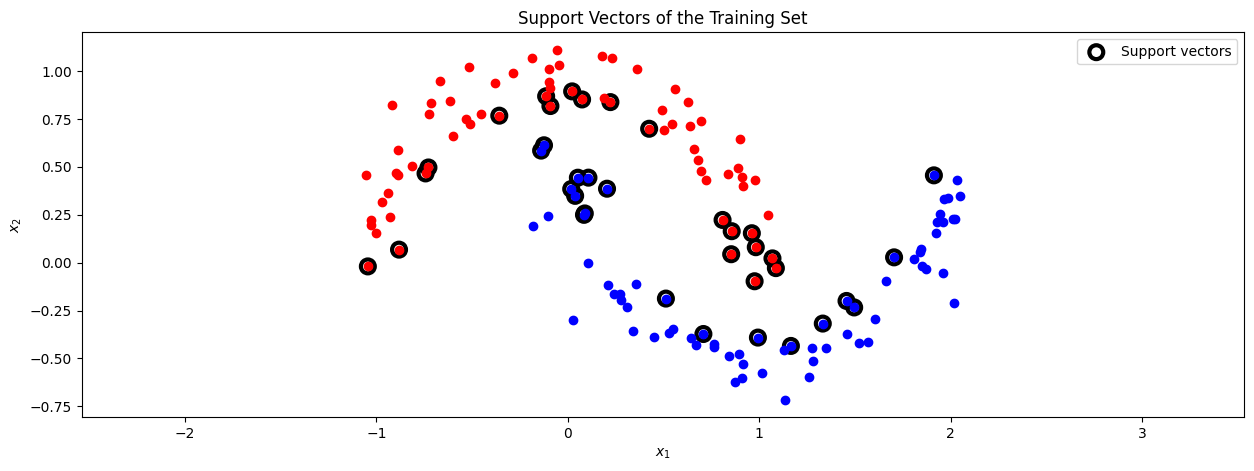

Well classified points:
[[ 6.38074748e-01  7.13346777e-01]
 [ 1.84417492e+00  7.22634450e-02]
 [ 9.61833524e-01  1.53773098e-01]
 [ 1.91298824e+00  4.56196167e-01]
 [ 1.33244065e+00 -3.18192336e-01]
 [-9.95355838e-02  1.01064530e+00]
 [-6.68328970e-01  9.51144265e-01]
 [ 2.22909221e-01  8.38849373e-01]
 [ 1.81007475e+00  1.73779292e-02]
 [ 8.40846106e-01 -4.89802400e-01]
 [ 9.15361249e-01 -5.30836070e-01]
 [ 1.92600317e+00  1.57518434e-01]
 [ 1.12997481e+00 -4.56026423e-01]
 [ 1.06955833e+00  2.23274098e-02]
 [ 4.51556172e-01 -3.86964399e-01]
 [ 6.82112273e-01  5.34374902e-01]
 [ 2.42497921e-01 -1.63694993e-01]
 [-7.24955918e-01  7.75536952e-01]
 [ 1.06624155e-01  3.89199936e-04]
 [-9.70418935e-01  3.16587235e-01]
 [-9.48907884e-02  9.13765681e-01]
 [-8.13147290e-01  5.04335343e-01]
 [-3.57668342e-01  7.68008542e-01]
 [ 1.08735914e+00 -2.85131198e-02]
 [-1.12915563e-01  8.69412987e-01]
 [ 5.30410761e-01 -3.66965171e-01]
 [-4.69141871e-02  1.03140390e+00]
 [ 1.98585052e+00  3.36454315e-

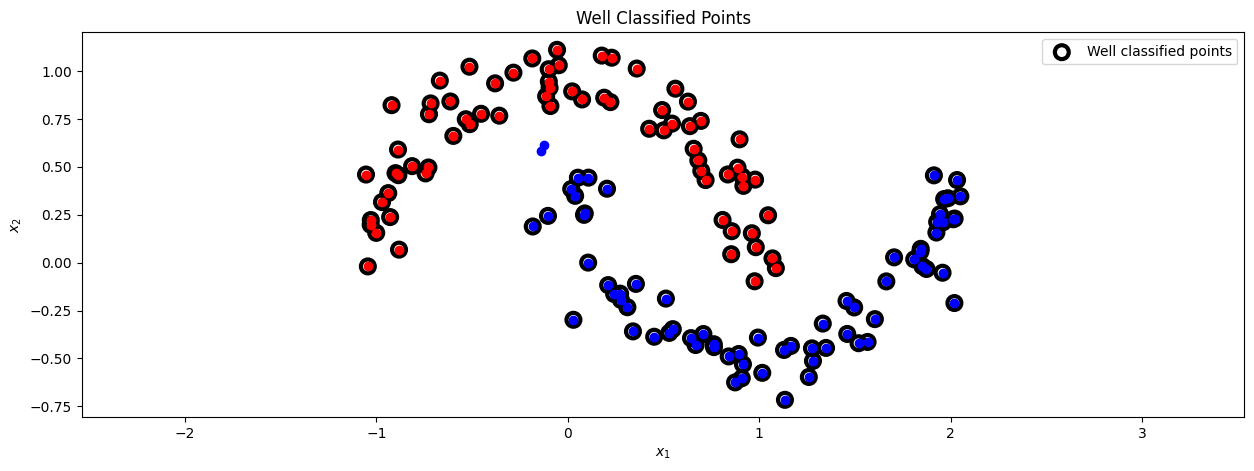

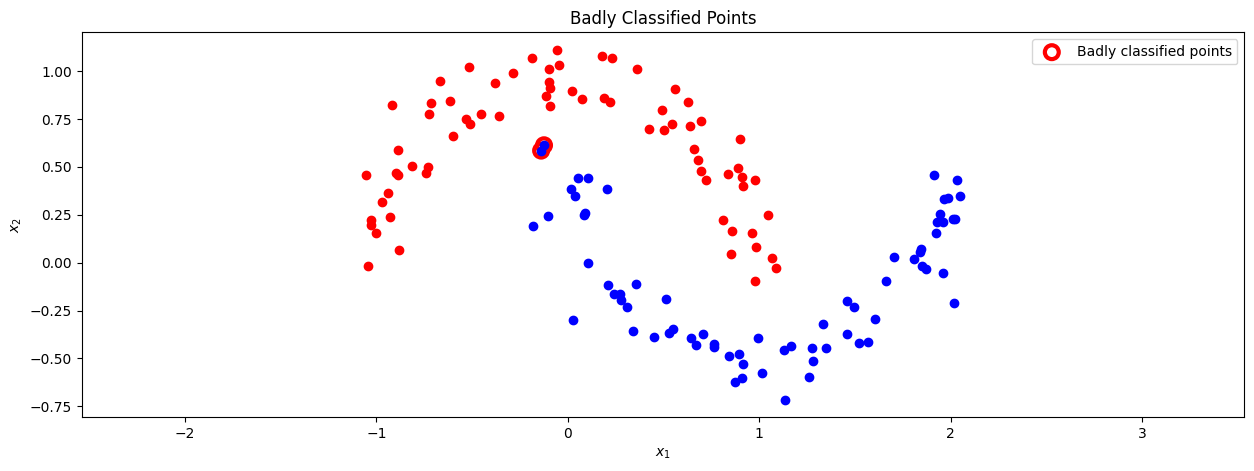

Points that lie on the supporting hyperplanes:
[[ 0.42532529  0.69964593]
 [-1.04434178 -0.01958817]
 [ 0.02300611  0.89485816]
 [-0.51219521  0.72357782]
 [-0.72779681  0.49724573]
 [ 0.08492022  0.24984896]
 [ 1.49643186 -0.23391909]
 [ 0.51282898 -0.18762429]
 [ 1.16590578 -0.43503121]]



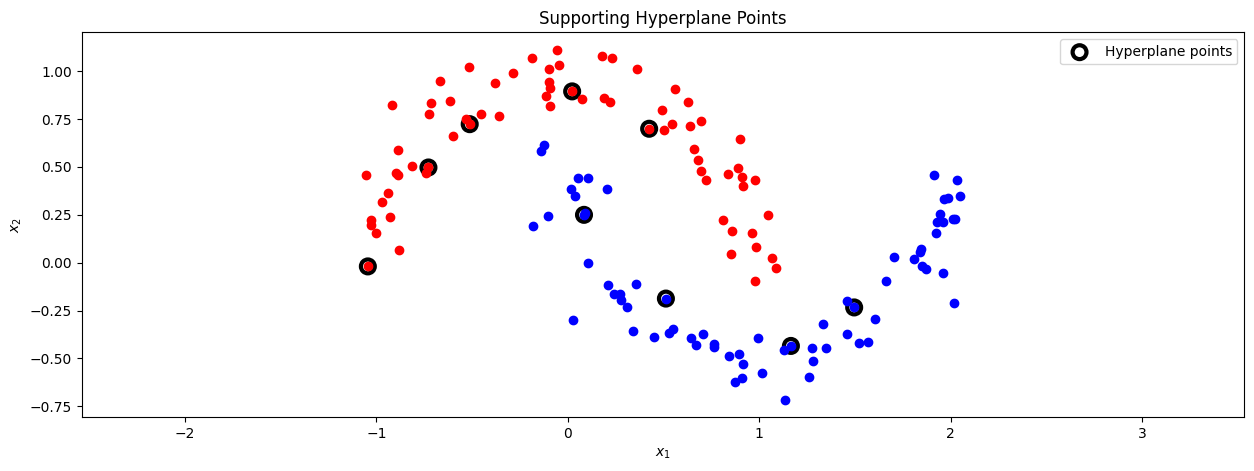

Wrong side well-classified points of MySVC:
[[ 0.96183352  0.1537731 ]
 [ 1.91298824  0.45619617]
 [ 1.33244065 -0.31819234]
 [ 0.22290922  0.83884937]
 [ 1.06955833  0.02232741]
 [-0.35766834  0.76800854]
 [ 1.08735914 -0.02851312]
 [-0.11291556  0.86941299]
 [ 0.85661518  0.16443333]
 [ 0.03861244  0.3490792 ]
 [-0.88141539  0.06810258]
 [ 0.10814845  0.44418536]
 [-1.04434178 -0.01958817]
 [ 0.85386488  0.04412433]
 [ 0.08904053  0.25713775]
 [ 0.01807798  0.38488377]
 [ 0.20522809  0.38637198]
 [ 0.05289285  0.44384578]
 [ 0.08492022  0.24984896]
 [-0.09050691  0.81835056]
 [ 0.07493939  0.85271149]
 [ 0.99356792 -0.39137127]
 [ 0.98239893  0.08077338]
 [-0.74289036  0.46626099]
 [ 0.80890917  0.22318325]
 [ 0.97621719 -0.09712865]
 [ 1.70496444  0.02775509]
 [ 1.16590578 -0.43503121]
 [ 1.4564899  -0.19998472]
 [ 0.70872844 -0.3727295 ]]



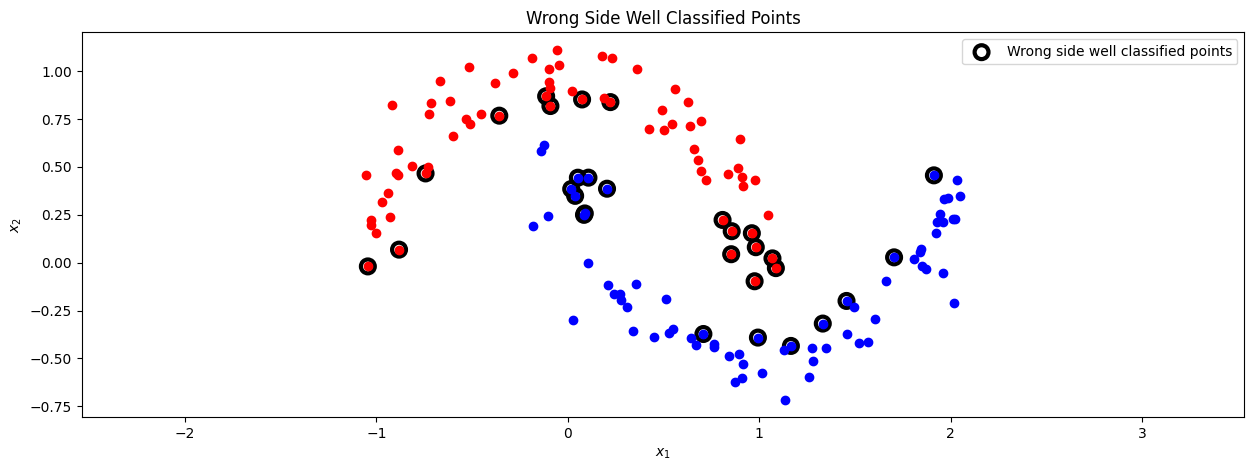

In [64]:
def plot_points(title, points, edge_color, label, x_data, y_data):
    """
    Función genérica para graficar puntos con una etiqueta específica.
    """
    plt.scatter(
        points[:, 0], points[:, 1],
        s=100,
        linewidth=3,
        facecolors="none",
        edgecolors=edge_color,
        label=label,
    )
    plot_dataset_clas(x_data, y_data)
    plt.title(title)
    plt.legend()
    plt.show()

#########################################################################################
# 1. Support vectors
support_vectors_my = model_my.support_vectors_
support_vectors_sk = model_sk.support_vectors_

print("Support vectors of MySVC:")
print(support_vectors_my)
print("\nSupport vectors of sci-kit learn SVC:")
print(support_vectors_sk)
print()

plot_points(
    title="Support Vectors of the Training Set",
    points=support_vectors_my,
    edge_color="k",
    label="Support vectors",
    x_data=x_tr,
    y_data=y_tr
)

#########################################################################################
# 2. Well and badly classified points
well_classified_points, badly_classified_points = model_my.get_classification_status(x_tr, y_tr)

print("Well classified points:")
print(well_classified_points)
print("\nBadly classified points:")
print(badly_classified_points)
print()

plot_points(
    title="Well Classified Points",
    points=well_classified_points,
    edge_color="k",
    label="Well classified points",
    x_data=x_tr,
    y_data=y_tr
)

plot_points(
    title="Badly Classified Points",
    points=badly_classified_points,
    edge_color="r",
    label="Badly classified points",
    x_data=x_tr,
    y_data=y_tr
)

#########################################################################################
# 3. Hyperplane points
hyperplane_points = model_my.get_supporting_hyperplane_points(x_tr, y_tr)

print("Points that lie on the supporting hyperplanes:")
print(hyperplane_points)
print()

plot_points(
    title="Supporting Hyperplane Points",
    points=hyperplane_points,
    edge_color="k",
    label="Hyperplane points",
    x_data=x_tr,
    y_data=y_tr
)

#########################################################################################
# 4. Wrong side well-classified points
wrong_side_well_classified_points = model_my.get_wrong_side_well_classified(x_tr, y_tr)

print("Wrong side well-classified points of MySVC:")
print(wrong_side_well_classified_points)
print()

plot_points(
    title="Wrong Side Well Classified Points",
    points=wrong_side_well_classified_points,
    edge_color="k",
    label="Wrong side well classified points",
    x_data=x_tr,
    y_data=y_tr
)
